In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from iobs.layers import IOBLayer
from iobs.models import BaseAE
from torch import nn, optim
import os
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [106]:
def plot_dynamic_spectra(dynamic_spectra, title="Dynamic Spectra"):
    """
    Plot a dynamic spectrum with horizontal time axis and reversed frequency axis.

    Parameters:
        dynamic_spectra (numpy.ndarray): The dynamic spectrum to plot.
        title (str): The title for the plot (default is "Dynamic Spectra").

    Returns:
        None
    """
    # Calculate the time step based on the number of time samples
    num_time_samples = dynamic_spectra.shape[0]
    time_step = 0.0000256  # Default time step in seconds

    # Calculate the extent based on the number of frequency channels
    extent = [0, num_time_samples * time_step * 1000, 1208, 1700]

    plt.figure(figsize=(10, 6))
    plt.imshow(dynamic_spectra.T, aspect="auto", cmap="viridis", extent=extent)
    plt.xlabel("Time (ms)", size=14)
    plt.ylabel("Frequency (MHz)", size=14)
    plt.colorbar()
    plt.title(title, size=16)
    plt.show()

In [107]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [108]:
# directories = [
#     "noiseless_1000_simple_narrow",
#     "noiseless_1000_simple_broad",
#     "noiseless_1000_simple_middle",
#     "noiseless_1000_simple_broad_narrow_time",
#     "noiseless_1000_scattered",
#     "noiseless_1000_complex",
#     "noiseless_1000_drifting",
# ]

# Define the directories containing the data for different classes
directories = [
    "1000_Constant_SNR_simple_narrow",
    "1000_Constant_SNR_simple_broad",
    "1000_Constant_SNR_simulated_scattered",
    "1000_Constant_SNR_complex",
    "1000_Constant_SNR_drifting",
]

# Define the directories containing the data for different classes
# directories = [
#     "1000_Constant_SNR_simple_narrow_res",
#     "1000_Constant_SNR_simple_broad_res",
#     "1000_Constant_SNR_simulated_scattered_res",
#     "1000_Constant_SNR_complex_res",
#     "1000_Constant_SNR_drifting_res",
# ]

# Initialize lists to store data and corresponding labels
data = []
labels = []

# Iterate over each class directory
for class_idx, directory in enumerate(directories):
    # Construct the full path to the data directory
    data_dir = f"data/{directory}"
    data_per_directory = []

    # Iterate over each file in the directory
    for filename in os.listdir(data_dir):
        if filename.endswith(".npy"):
            # Load the dynamic spectra with pulse from the file
            dynamic_spectra_w_pulse = np.load(os.path.join(data_dir, filename))
            
            # Rebin the spectrum to a smaller size
            rebinned_spectrum = rebin(dynamic_spectra_w_pulse, (int(1024/4), int(512/4)))
            
            # Ensure no zero values in the rebinned spectrum to avoid issues during processing
            if np.any(rebinned_spectrum == 0.0):
                rebinned_spectrum[rebinned_spectrum == 0] = 0.0001
            
            # Append the rebinned spectrum to the list of data for this class
            data_per_directory.append(rebinned_spectrum)
            
            # Append the class index as the label for this data point
            labels.append(class_idx)

    # Limit the number of data points per class
    data_per_directory = np.array(data_per_directory)[:1000]
    
    # Append the data for this class to the overall data list
    data.append(data_per_directory)

# Concatenate the data and labels for all classes
data = np.concatenate(data, axis=0)
labels = np.array(labels)

# Split the data into training and testing sets while maintaining class balance
test_size = 0.2
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=test_size, shuffle=True, random_state=42)


In [109]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


## Prep data for Network

In [110]:
# Convert data to PyTorch tensors
data_train_tensor = torch.Tensor(data_train[:, None, :])
data_test_tensor = torch.Tensor(data_test[:, None, :])

# Convert labels to PyTorch tensors
labels_train_tensor = torch.LongTensor(labels_train)
labels_test_tensor = torch.LongTensor(labels_test)

# Create weights for training data
train_weights = np.zeros_like(data_train_tensor)

# Calculate the minimum absolute value for every spectrum and add it to the weights list
for i, spectra in enumerate(data_train_tensor):
    min_abs_value = torch.min(torch.abs(spectra))
    train_weights[i, :, :, :]=(torch.log((torch.abs(spectra) / min_abs_value.item())) + 0.1)

# Convert weights to pytorch tensor
train_weights_tensor = torch.tensor(train_weights)

# Create weights for test data
test_weights = np.zeros_like(data_test_tensor)

# Calculate the minimum absolute value for every spectrum and add it to the weights list
for i, spectra in enumerate(data_test_tensor):
    min_abs_value = torch.min(torch.abs(spectra))
    test_weights[i, :, :, :]=(torch.log((torch.abs(spectra) / min_abs_value.item())) + 0.1)

# Convert weights to pytorch tensor
test_weights_tensor = torch.tensor(test_weights)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(data_train_tensor, train_weights_tensor, labels_train_tensor)
test_dataset = TensorDataset(data_test_tensor, test_weights_tensor, labels_test_tensor)

batch_size = 16  # Adjust as needed
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Define my own Loss Function to give more importance to signal

In [111]:
# Define weighted loss function to give more strength to signal
class weighted_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, inputs, targets, weights):
        return torch.sum(((inputs - targets) ** 2 ) * weights)

## Convolutional Neural Network

In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self, embedding_size=24, num_filters=8):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # 
        self.conv1 = nn.Conv2d(1, num_filters, 3, padding=1)  
        # 
        self.conv2 = nn.Conv2d(num_filters, num_filters, 3, padding=1)
        
        self.conv3 = nn.Conv2d(num_filters, num_filters, 3, padding=1)
        
        #self.conv4 = nn.Conv2d(num_filters, num_filters, 3, padding=1)
        
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        # compute the flattened size after convolutions
        self.shape_before_flattening = (num_filters,32, 16)
        flattened_size = num_filters * 32 * 16 #
        # define fully connected layer to create embeddings
        
        self.embedding_size = embedding_size
        
        self.lin1 = nn.Linear(flattened_size, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, flattened_size)
        # store the shape before flattening
        self.reshape_dim = self.shape_before_flattening
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(num_filters, num_filters, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(num_filters, num_filters, 2, stride=2)
        #self.t_conv3 = nn.ConvTranspose2d(num_filters, num_filters, 2, stride=2)
        self.t_conv4 = nn.ConvTranspose2d(num_filters, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # 
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        #x = self.pool(x)
        #x = F.relu(self.conv4(x))
        
        x = self.pool(x)  # compressed representation
        
        # flatten the tensor
        x = x.view(x.size(0), -1)
        
        z = self.lin1(x)
        
        x = self.lin2(z)
        x = x.view(x.size(0), *self.reshape_dim)
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv4(x))
                
        return x, z

# initialize the NN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder(embedding_size=8).to(device)

# specify loss function
# criterion = nn.BCELoss()
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    # Training
    model.train()
    for data, weights, _ in train_loader:
        images = data.to(device)
        
        optimizer.zero_grad()
        
        outputs, z = model(images)
        
        loss = criterion(outputs, images)
        
        loss.backward()
        
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()*images.size(0)
    
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.595665
Epoch: 2 	Training Loss: 0.069653
Epoch: 3 	Training Loss: 0.063639
Epoch: 4 	Training Loss: 0.048464
Epoch: 5 	Training Loss: 0.033087
Epoch: 6 	Training Loss: 0.026063
Epoch: 7 	Training Loss: 0.022086
Epoch: 8 	Training Loss: 0.018826
Epoch: 9 	Training Loss: 0.016240
Epoch: 10 	Training Loss: 0.014682
Epoch: 11 	Training Loss: 0.014005
Epoch: 12 	Training Loss: 0.013315
Epoch: 13 	Training Loss: 0.012759
Epoch: 14 	Training Loss: 0.012173
Epoch: 15 	Training Loss: 0.011633
Epoch: 16 	Training Loss: 0.011240
Epoch: 17 	Training Loss: 0.010908
Epoch: 18 	Training Loss: 0.010666
Epoch: 19 	Training Loss: 0.010311
Epoch: 20 	Training Loss: 0.010169
Epoch: 21 	Training Loss: 0.009958
Epoch: 22 	Training Loss: 0.009839
Epoch: 23 	Training Loss: 0.009673
Epoch: 24 	Training Loss: 0.009456
Epoch: 25 	Training Loss: 0.009200
Epoch: 26 	Training Loss: 0.009037
Epoch: 27 	Training Loss: 0.008916
Epoch: 28 	Training Loss: 0.008716
Epoch: 29 	Training Loss: 0.0

## Look at CNN reconstruction

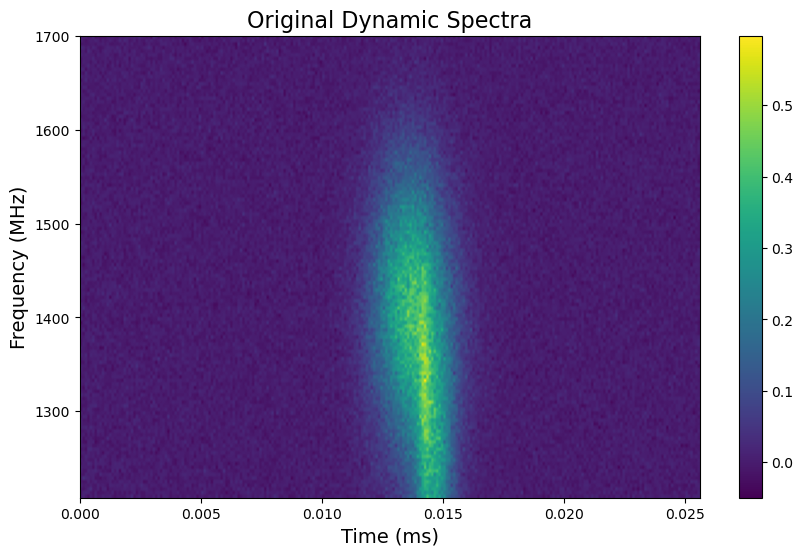

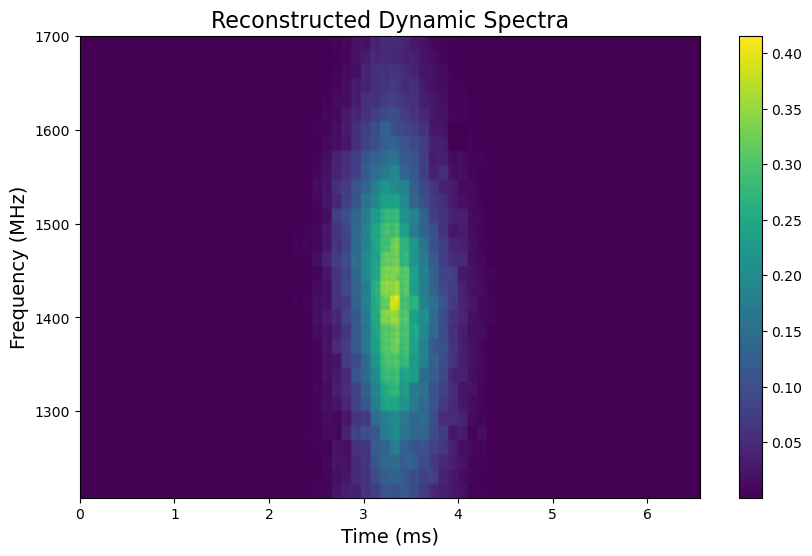

In [127]:
# Assuming data_test_tensor is of shape [batch_size, channels, height, width]
batch_size, channels, height, width = data_test_tensor.shape
# Reshape data_test_tensor to match the expected input shape of the model
inputs = data_test_tensor.to(device)  # Move data to the GPU

# Testing the autoencoder
model.eval()
with torch.no_grad():
    reconstructed, _ = model(inputs)  # Unpack the output tuple to get the reconstructed tensor

# Convert tensors to numpy arrays for plotting
original_np = data_test_tensor[idx].cpu().numpy()  # Move data back to CPU for plotting
reconstructed_np = reconstructed[idx, 0].cpu().numpy()  # Move data back to CPU for plotting

# Visualize original and reconstructed data
plot_dynamic_spectra(original_np, title="Original Dynamic Spectra")
plot_dynamic_spectra(reconstructed_np, title="Reconstructed Dynamic Spectra")



## Look at Latent Space representation

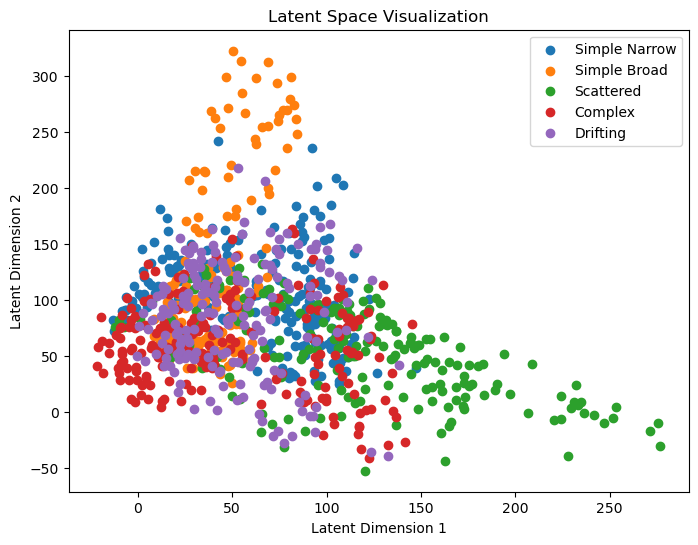

In [153]:
# Assuming data_test_tensor is of shape [batch_size, channels, height, width]
batch_size, channels, height, width = data_test_tensor.shape

# Reshape data_test_tensor to match the expected input shape of the model
inputs = data_test_tensor.to(device)  # Move data to the GPU

# Pass the input data through the encoder part of the autoencoder to obtain the encoded representations
encoded_representations = []
burst_labels_all = []  # Initialize list to store burst labels

# Testing the autoencoder
model.eval()
with torch.no_grad():
    reconstructed, encoded = model(inputs)  # Unpack the output tuple to get the reconstructed tensor
    encoded_representations.append(encoded.cpu().numpy())
    # Populate burst_labels_all with burst labels associated with each data point
    burst_labels_all.extend(labels_test)

# Concatenate encoded representations from different batches
encoded_representations = np.concatenate(encoded_representations, axis=0)

# Define burst categories and colors
burst_categories = np.unique(burst_labels_all)
num_categories = len(burst_categories)

# Define labels for each directory
burst_labels = [
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
]

# Visualize the encoded representations in a 2D space
plt.figure(figsize=(8, 6))
for i, category in enumerate(burst_categories):
    indices = np.where(np.array(burst_labels_all) == category)[0]
    plt.scatter(encoded_representations[indices, 2], encoded_representations[indices, 3], label=f'{burst_labels[i]}')

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.legend()
plt.show()

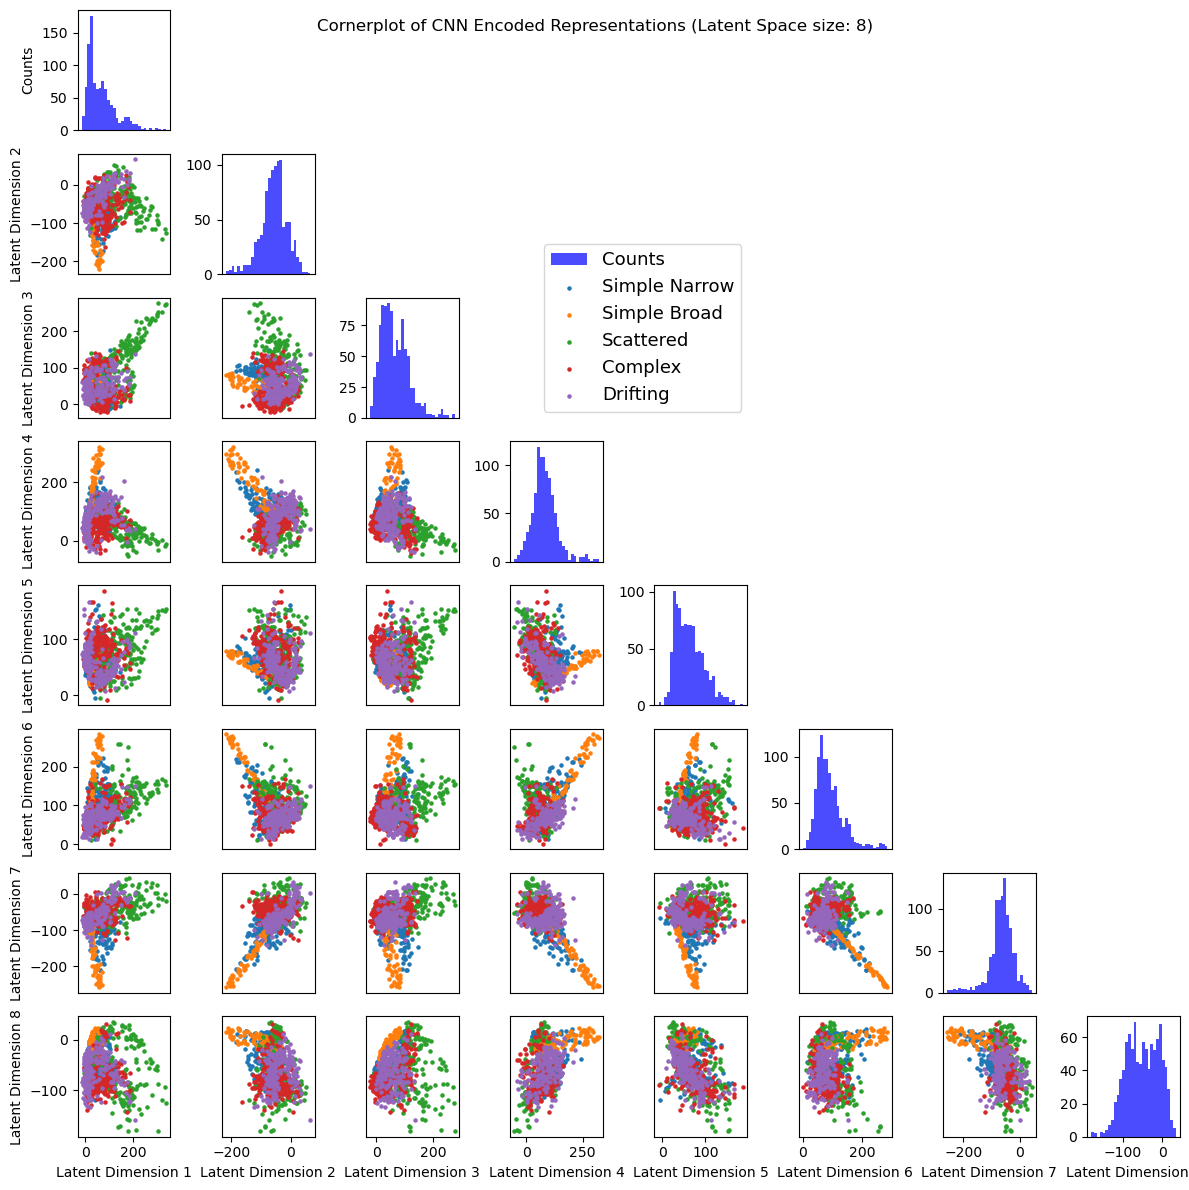

In [155]:
# Define burst categories and colors
burst_categories = np.unique(labels_test)
num_categories = len(burst_categories)

# Define labels for each directory
burst_labels = [
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
]

# Create a square grid of subplots
fig, axes = plt.subplots(encoded_representations.shape[1], encoded_representations.shape[1], figsize=(12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Plot histograms on the diagonal
for i in range(encoded_representations.shape[1]):
    axes[i, i].hist(encoded_representations[:, i], bins=30, color='blue', alpha=0.7)
    if i == 0:
        axes[i, i].set_ylabel('Counts')
    if i == encoded_representations.shape[1] - 1:
        axes[i, i].set_xlabel(f'Latent Dimension {i+1}')
        axes[i, i].tick_params(axis='x', bottom=True, top=False)
    else:
        axes[i, i].tick_params(axis='x', bottom=False, top=False, labelbottom=False)

# Plot scatter plots on the off-diagonal
for i in range(encoded_representations.shape[1]):
    for j in range(i + 1, encoded_representations.shape[1]):
        for k, category in enumerate(burst_categories):
            indices = np.where(np.array(labels_test) == category)[0]
            axes[j, i].scatter(encoded_representations[indices, i], encoded_representations[indices, j], label=burst_labels[k], s=5)
        axes[i, j].set_axis_off()
        # Adjust y-axis labels and ticks
        if j == encoded_representations.shape[1] - 1:
            axes[j, i].set_xlabel(f'Latent Dimension {i+1}')
            axes[j, i].tick_params(axis='x', bottom=True, top=False)
        else:
            axes[j, i].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
        if i == 0:
            axes[j, i].set_ylabel(f'Latent Dimension {j+1}')
            axes[j, i].tick_params(axis='y', left=True, right=False)
        else:
            axes[j, i].tick_params(axis='y', left=False, right=False, labelleft=False)

# Add legend outside the subplots
fig.legend([
    "Counts",
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
],loc='upper left', bbox_to_anchor=(0.45, 0.8), fontsize='13')

# Adjust layout for better visualization
plt.tight_layout()

plt.suptitle("Cornerplot of CNN Encoded Representations (Latent Space size: 8)")

# Show the plot
plt.show()

## UMAP on latent space

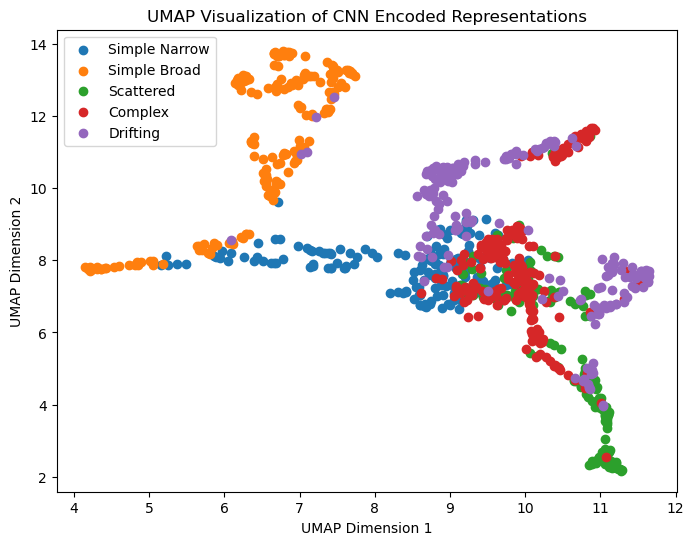

In [158]:
import umap

# Assuming encoded_representations contains the latent space representations from the CNN model

# Create a UMAP reducer
reducer = umap.UMAP(n_components=3)

# Fit and transform the encoded representations using UMAP
umap_embeddings = reducer.fit_transform(encoded_representations)

# Define burst categories and colors
burst_categories = np.unique(burst_labels_all)
num_categories = len(burst_categories)

# Plot the UMAP embeddings with burst category colors
plt.figure(figsize=(8, 6))
for i, category in enumerate(burst_categories):
    indices = np.where(np.array(burst_labels_all) == category)[0]
    plt.scatter(umap_embeddings[indices, 0], umap_embeddings[indices, 1], label=f'{burst_labels[i]}')

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization of CNN Encoded Representations')
plt.legend()
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


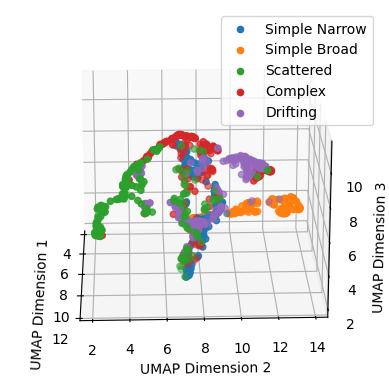

In [160]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define burst categories and colors
burst_categories = np.unique(burst_labels_all)
num_categories = len(burst_categories)

# Create a function to update the view angle
def update_angle(frame):
    ax.cla()
    ax.view_init(elev=20, azim=frame)  # Adjust the elevation and azimuth angles
    for i, category in enumerate(burst_categories):
        indices = np.where(np.array(burst_labels_all) == category)[0]
        ax.scatter(
            umap_embeddings[indices, 0], umap_embeddings[indices, 1], umap_embeddings[indices, 2],
            label=f'{burst_labels[i]}'
        )
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_zlabel('UMAP Dimension 3')
    ax.legend()

# Initialize FuncAnimation
ani = FuncAnimation(fig, update_angle, frames=np.arange(0, 360, 2), repeat=True)

# Save the animation as a GIF
ani.save('umap_animation.gif', writer='imagemagick', fps=15)

plt.show()


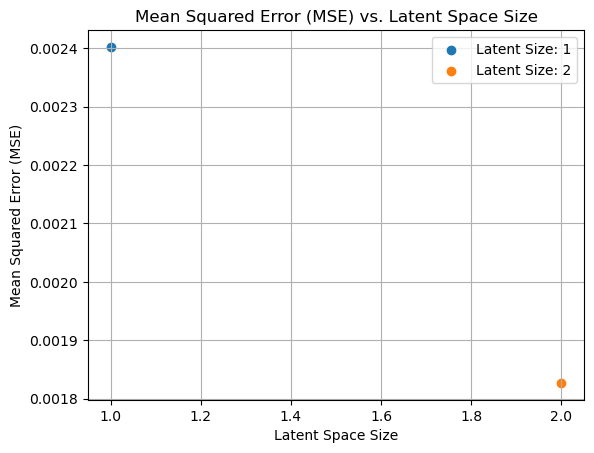

Latent Size: 1, Final Epoch Losses: [0.002446854051668197]
Latent Size: 2, Final Epoch Losses: [0.0018116542662028224]


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

# Define the range of latent space sizes
latent_sizes = [1,2]

# Initialize lists to store MSE values and epoch losses
mse_values = []
epoch_losses_final = []
best_mse = float('inf')
worst_mse = 0

# Store best and worst network
best_network = None
worst_network = None

# Define the loss function
criterion = nn.MSELoss()

# Iterate over different latent space sizes
for latent_size in latent_sizes:
    # Initialize list to store MSE values for each run
    run_mse = []
    run_epoch_losses_final = []
    for _ in range(1):  # Perform 10 runs for each latent space size
        # Initialize the convolutional autoencoder
        model = ConvAutoencoder(embedding_size=latent_size).to(device)

        # Define the optimizer
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Initialize early stopping parameters
        best_loss = float('inf')
        patience = 20
        counter = 0

        # Training the autoencoder
        num_epochs = 100
        epoch_losses = []
        for epoch in range(1, num_epochs + 1):
            model.train()  # Set model to training mode
            train_loss = 0.0
            for data in train_loader:
                inputs = data.to(device)
                optimizer.zero_grad()
                outputs, _ = model(inputs)
                loss = criterion(outputs, inputs)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
            epoch_loss = train_loss / len(train_loader.dataset)
            epoch_losses.append(epoch_loss)

            # Early stopping
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    break

        # Save the trained model
        model_path = f'saved_models/conv_autoencoder_latent_{latent_size}.pt'
        torch.save({
            'state_dict': model.state_dict(),
            'latent_size': latent_size
        }, model_path)

        # Evaluate the trained model on test data
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            test_loss = 0.0
            for data in test_loader:
                inputs = data.to(device)
                outputs, _ = model(inputs)
                test_loss += criterion(outputs, inputs).item() * inputs.size(0)
            test_loss /= len(test_loader.dataset)
            run_mse.append(test_loss)
        
        # Update best and worst MSE
        if test_loss < best_mse:
            best_mse = test_loss
            best_network = model.state_dict()
        if test_loss > worst_mse:
            worst_mse = test_loss
            worst_network = model.state_dict()
        
        # Store the epoch loss for the final epoch of this run
        run_epoch_losses_final.append(epoch_losses[-1])

    # Store the MSE values and epoch losses for all runs for this latent size
    mse_values.append(run_mse)
    epoch_losses_final.append(run_epoch_losses_final)

# Plot MSE as a function of latent space size
for idx, mse_list in enumerate(mse_values):
    plt.scatter([latent_sizes[idx]] * len(mse_list), mse_list, label=f'Latent Size: {latent_sizes[idx]}')

plt.title('Mean Squared Error (MSE) vs. Latent Space Size')
plt.xlabel('Latent Space Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Print the epoch losses for the final epoch of each run
for idx, epoch_losses in enumerate(epoch_losses_final):
    print(f"Latent Size: {latent_sizes[idx]}, Final Epoch Losses: {epoch_losses}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import os

# Define the range of latent space sizes
latent_sizes = np.arange(1,26)

# Initialize lists to store MSE values and epoch losses
mse_values = []
epoch_losses_final = []
best_mse = float('inf')
worst_mse = 0

# Store best and worst network
best_network = None
worst_network = None

# Define the loss function
criterion = nn.MSELoss()

# Iterate over different latent space sizes
for latent_size in latent_sizes:
    # Initialize list to store MSE values for each run
    run_mse = []
    run_epoch_losses_final = []
    for _ in range(1):  # Perform 10 runs for each latent space size
        # Initialize the convolutional autoencoder
        model = ConvAutoencoder(embedding_size=latent_size).to(device)

        # Define the optimizer
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Initialize early stopping parameters
        best_loss = float('inf')
        patience = 20
        counter = 0

        # Training the autoencoder
        num_epochs = 100
        epoch_losses = []
        for epoch in range(1, num_epochs + 1):
            model.train()  # Set model to training mode
            train_loss = 0.0
            for data, _, _ in train_loader:
                inputs = data.to(device)
                optimizer.zero_grad()
                outputs, _ = model(inputs)
                loss = criterion(outputs, inputs)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
            epoch_loss = train_loss / len(train_loader.dataset)
            epoch_losses.append(epoch_loss)

            # Early stopping
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    break

        # Save the trained model
        model_path = f'saved_models/_res_conv_autoencoder_latent_{latent_size}.pt'
        torch.save({
            'state_dict': model.state_dict(),
            'latent_size': latent_size
        }, model_path)

        # Evaluate the trained model on test data
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            test_loss = 0.0
            for data, _, _ in test_loader:
                inputs = data.to(device)
                outputs, _ = model(inputs)
                test_loss += criterion(outputs, inputs).item() * inputs.size(0)
            test_loss /= len(test_loader.dataset)
            run_mse.append(test_loss)
        
        # Update best and worst MSE
        if test_loss < best_mse:
            best_mse = test_loss
            best_network = model.state_dict()
        if test_loss > worst_mse:
            worst_mse = test_loss
            worst_network = model.state_dict()
        
        # Store the epoch loss for the final epoch of this run
        run_epoch_losses_final.append(epoch_losses[-1])

    # Store the MSE values and epoch losses for all runs for this latent size
    mse_values.append(run_mse)
    epoch_losses_final.append(run_epoch_losses_final)

# Plot MSE as a function of latent space size
for idx, mse_list in enumerate(mse_values):
    plt.scatter([latent_sizes[idx]] * len(mse_list), mse_list, label=f'Latent Size: {latent_sizes[idx]}')

plt.title('Mean Squared Error (MSE) vs. Latent Space Size')
plt.xlabel('Latent Space Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Print the epoch losses for the final epoch of each run
for idx, epoch_losses in enumerate(epoch_losses_final):
    print(f"Latent Size: {latent_sizes[idx]}, Final Epoch Losses: {epoch_losses}")


## Evaluate the networks

In [ ]:
import torch
import torch.nn as nn
import os

# Define the desired latent size
latent_size = 2

# Define the model with the desired latent size
model = ConvAutoencoder(latent_size).to(device)

# Load the state dictionary
checkpoint = torch.load('saved_models/res_conv_autoencoder_latent_2.pt')
model.load_state_dict(checkpoint['state_dict'])


In [ ]:
# Define the range of latent space sizes
latent_sizes = np.arange(1,26)

# Initialize lists to store results
reconstruction_errors_per_label = {label: [] for label in set(labels_test)}
reconstruction_errors = []

# Testing each model for different latent space sizes
for latent_size in latent_sizes:
    # Load the model for the current latent size
    model = ConvAutoencoder(latent_size).to(device)
    checkpoint = torch.load(f'saved_models/conv_autoencoder_latent_{latent_size}.pt')
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()

    reconstructed_all = []

    with torch.no_grad():
        for batch_data, _, batch_labels in test_loader:  # Extract only batch_data and batch_labels
            batch_data = batch_data.to(device)  # Move input data to the GPU
            reconstructed_batch, _ = model(batch_data)  # Forward the batch through the model
            reconstructed_batch = reconstructed_batch.detach().cpu().numpy()
            reconstructed_all.append(reconstructed_batch)

    # Concatenate reconstructed batches
    reconstructed_all = np.concatenate(reconstructed_all, axis=0)

    # Calculate Mean Squared Error (MSE) for the current bottleneck width
    mse_all = mean_squared_error(data_test.flatten(), reconstructed_all.flatten())
    
    # Store reconstruction error (MSE) and bottleneck size
    reconstruction_errors.append(mse_all)
    
    # Iterate over each label
    for label in set(labels_test):
        # Select reconstructed data for the current label
        reconstructed = reconstructed_all[labels_test == label]

        # Calculate Mean Squared Error (MSE) for the current label and latent size
        mse = mean_squared_error(data_test[labels_test == label].flatten(), reconstructed.flatten())

        # Store reconstruction error (MSE) for the current label and latent size
        reconstruction_errors_per_label[label].append(mse)

# Define labels for each directory
burst_labels = [
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
]

# Plot the reconstruction error (MSE) vs. latent space size for each label
plt.figure(figsize=(10, 6))
for idx, (label, errors) in enumerate(reconstruction_errors_per_label.items()):
    plt.plot(latent_sizes, errors, marker='o', label=f'{burst_labels[label]}')
    
plt.plot(latent_sizes, reconstruction_errors, marker='o', color='black', label='All classes combined')

plt.xlabel('Latent Space Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Reconstruction Error vs. Latent Space Size for Convolutional Autoencoder')
plt.legend()
plt.grid(True)
plt.show()


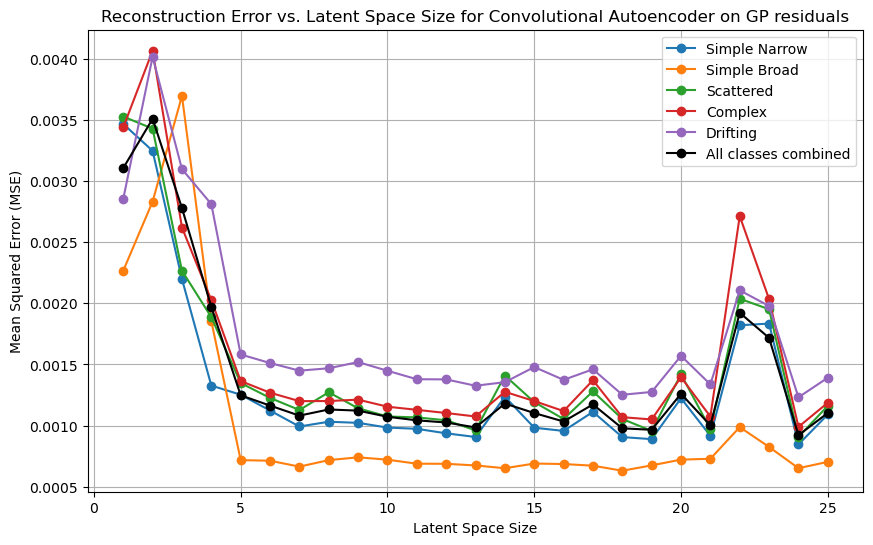

In [87]:
# Define labels for each directory
burst_labels = [
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
]

# Plot the reconstruction error (MSE) vs. latent space size for each label
plt.figure(figsize=(10, 6))
for idx, (label, errors) in enumerate(reconstruction_errors_per_label.items()):
    plt.plot(latent_sizes, errors, marker='o', label=f'{burst_labels[label]}')
    
plt.plot(latent_sizes, reconstruction_errors, marker='o', color='black', label='All classes combined')

plt.xlabel('Latent Space Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Reconstruction Error vs. Latent Space Size for Convolutional Autoencoder on GP residuals')
plt.legend()
plt.grid(True)
plt.show()